# 多次元への拡張

## 2次元Gaussian Hill 問題

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

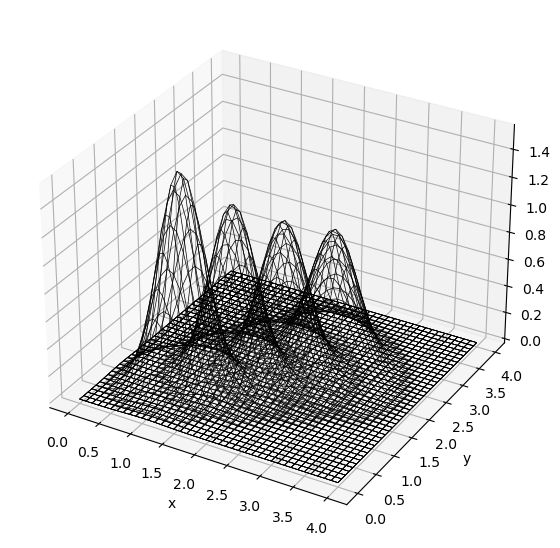

In [99]:
c = 1.
d = 1.
dt = .05
dx = .1
dy = .1
jmax = 41
kmax = 41
nmax = 30
nfig = 1

def init(dx, dy, jmax, kmax):
    x = np.linspace(0, dx * (jmax - 1), jmax)
    y = np.linspace(0, dy * (kmax - 1), kmax)
    q = init_q(x, y, jmax, kmax)
    return (x, y, q)

def init_q(x, y, jmax, kmax):
    def gausfunc(x, y, mu, V):
        """
        マハラノビス距離の計算がトリッキーな気がする。
        軸も省略されているので意味がわからない。
        次のセルで示したような行列積とアダマール積を使ったよく見る実装で十分だと思う.         
        """
        detV = np.linalg.det(V)
        invV = np.linalg.inv(V)
        A    = 1. / (2 * np.pi * np.sqrt(detV))
        dX   = (np.array([x, y]) - mu[:, None, None]).transpose(1, 2, 0)
        return A * np.exp(-.5 * dX[:, :, None] @ invV[None, None] @ dX[:, :, :, None])

    mu = np.array([dx * jmax / 4., dy * kmax / 4.])
    V  = np.array([[dx * jmax / 40., 0], [0, dy * kmax / 40.]])
    X, Y = np.meshgrid(x, y)

    q = gausfunc(X, Y, mu, V)[:, :, 0, 0]

    return q

def do_computing(x, y, q, dt, dx, dy, nmax, interval = 2):
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize  = (7, 7 * nfig), dpi = 100)
    plt.rcParams["font.size"] = 10

    # 初期分布
    ax1 = fig.add_subplot(1, 1, 1, projection = "3d")
    ax1.plot_wireframe(X, Y, q, color = "black", rstride = 1, cstride = 1, linewidth = .5)
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    for n in range(1, nmax + 1):
        qold = q.copy()
        for j in range(1, jmax - 1):
            for k in range(1, kmax - 1):
                # 1次精度風上差分
                q[j][k] = qold[j][k] - dt / dx * (c * (qold[j][k] - qold[j-1][k]) + d * (qold[j][k] - qold[j][k-1]))

        if n % interval == 0:
            ax1.plot_wireframe(X, Y, q, color = "black", rstride = 1, cstride = 1, linewidth = .5)

    plt.show()


x, y, q = init(dx, dy, jmax, kmax)
do_computing(x, y, q, dt, dx, dy, nmax, interval = 10)




In [105]:
def gausfunc1(x, y, mu, V):
    detV = np.linalg.det(V)
    invV = np.linalg.inv(V)
    A    = 1. / (2. * np.pi * np.sqrt(detV))
    dX   = (np.array([x, y]) - mu[:, None, None]).transpose(1, 2, 0)
    return A * np.exp(-.5 * dX[:, :, None, :] @ invV[None, None, ...] @ dX[:, :, :, None])

def gausfunc2(x, y, mu, V):
   detV = np.linalg.det(V)
   invV = np.linalg.inv(V)
   A    = 1. / (2. * np.pi * np.sqrt(detV))
   dX   = np.stack([x, y], axis = 2).reshape(jmax * kmax, 2) - mu[None, :]
   mdX  = np.sum(dX @ invV * dX, axis = 1).reshape(jmax, kmax)
   return  A * np.exp(- .5 * mdX)  


mu = np.array([dx * jmax / 4., dy * kmax / 4.])
# 共分散行列？
V  = np.array([[dx * jmax / 40., 0], [0, dy * kmax / 40.]])
X, Y = np.meshgrid(x, y)
q = gausfunc(X, Y, mu, V)
q

array([[5.49006930e-05, 1.42130476e-04, 3.33753942e-04, ...,
        4.48217218e-19, 2.84793828e-20, 1.64135460e-21],
       [1.42130476e-04, 3.67956600e-04, 8.64043861e-04, ...,
        1.16037382e-18, 7.37292742e-20, 4.24924530e-21],
       [3.33753942e-04, 8.64043861e-04, 2.02896699e-03, ...,
        2.72481557e-18, 1.73132719e-19, 9.97817221e-21],
       ...,
       [4.48217218e-19, 1.16037382e-18, 2.72481557e-18, ...,
        3.65931036e-33, 2.32509811e-34, 1.34002570e-35],
       [2.84793828e-20, 7.37292742e-20, 1.73132719e-19, ...,
        2.32509811e-34, 1.47734974e-35, 8.51442187e-37],
       [1.64135460e-21, 4.24924530e-21, 9.97817221e-21, ...,
        1.34002570e-35, 8.51442187e-37, 4.90712373e-38]])

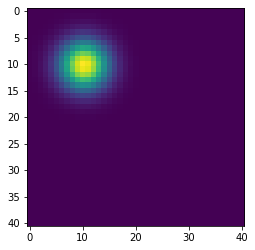

In [103]:
plt.imshow(q)

In [107]:
%timeit -n 100 gausfunc1(X, Y, mu, V)
%timeit -n 100 gausfunc2(X, Y, mu, V)

187 µs ± 7.49 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
83 µs ± 2.21 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


上記のように教科書記載の実装はそもそも遅い. 